# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [36]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [37]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=";")

In [38]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("azdias shape: ", azdias.shape)
print("feat_info shape: ", feat_info.shape)


azdias shape:  (891221, 85)
feat_info shape:  (85, 4)


In [39]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [40]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [41]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [42]:
feat_info.value_counts()

attribute         information_level  type         missing_or_unknown
AGER_TYP          person             categorical  [-1,0]                1
PLZ8_ANTG3        macrocell_plz8     ordinal      [-1]                  1
RETOURTYP_BK_S    person             ordinal      [0]                   1
RELAT_AB          community          ordinal      [-1,9]                1
REGIOTYP          region_rr1         ordinal      [-1,0]                1
                                                                       ..
HEALTH_TYP        person             ordinal      [-1,0]                1
GREEN_AVANTGARDE  person             categorical  []                    1
GFK_URLAUBERTYP   person             categorical  []                    1
GEBURTSJAHR       person             numeric      [0]                   1
ZABEOTYP          person             categorical  [-1,9]                1
Length: 85, dtype: int64

In [43]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [44]:
feat_info.attribute.value_counts()

AGER_TYP            1
MIN_GEBAEUDEJAHR    1
KBA05_ANTG3         1
KBA05_ANTG2         1
KBA05_ANTG1         1
                   ..
SEMIO_MAT           1
SEMIO_REL           1
SEMIO_FAM           1
SEMIO_SOZ           1
RELAT_AB            1
Name: attribute, Length: 85, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [45]:
# Identify missing or unknown data values and convert them to NaNs.
AGER_TYP_missing_or_unknown = azdias[(azdias['AGER_TYP'] == -1) | (azdias['AGER_TYP'] == 0)]
print("AGER_TYP % missing or unknown: {}%".format(round(AGER_TYP_missing_or_unknown.shape[0]/azdias.shape[0]*100, 2)))

GFK_URLAUBERTYP_missing_or_unknown = azdias[azdias['GFK_URLAUBERTYP'].isin([])]
print("ALTERSKATEGORIE_GROB % missing or unknown: {}%".format(round(GFK_URLAUBERTYP_missing_or_unknown.shape[0]/azdias.shape[0]*100, 2)))


AGER_TYP % missing or unknown: 76.96%
ALTERSKATEGORIE_GROB % missing or unknown: 0.0%


In [46]:
azdias['KONSUMNAEHE'].value_counts()

1.0    193738
3.0    171127
5.0    153535
2.0    134665
4.0    133324
6.0     26625
7.0      4238
Name: KONSUMNAEHE, dtype: int64

* In the next cell, I replace the custom missing values, indicated in `feat_info`, with `np.nan` in each column of `azdias`.

In [47]:
"""
Parse array:
    https://stackoverflow.com/questions/23119472/in-pandas-python-reading-array-stored-as-string

"""
import ast
df = azdias.copy()
for index, row in feat_info.iterrows():
    column_name = row.attribute
    
    try:
        missing_or_unknown_values = ast.literal_eval(row.missing_or_unknown)        
        df[column_name] = azdias[column_name].replace(to_replace=missing_or_unknown_values, value=np.nan)
    except:        
        print(missing_or_unknown_values)
        print(column_name)

df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)
df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)

df.head()

[-1]
CAMEO_DEUG_2015
[-1]
CAMEO_DEU_2015
[-1]
CAMEO_INTL_2015


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [48]:
df['CAMEO_DEUG_2015'].value_counts()

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64

In [49]:
feat_info[feat_info.attribute == "TITEL_KZ"]

,attribute,information_level,type,missing_or_unknown
40,TITEL_KZ,person,categorical,"[-1,0]"


In [50]:
df["TITEL_KZ"].value_counts()

1.0    1947
5.0     104
4.0      57
3.0      49
2.0       3
Name: TITEL_KZ, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [51]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Percentage of missing values for each column (in descending order)
na_counts = df.isna().sum()
na_percentages = round(df.isna().mean() * 100, 2)
null_values = pd.concat([na_counts, na_percentages, df.count()], axis=1, keys=["count", "%", "total"])
# Only print columns above 20%
print(null_values[null_values['%']>20].sort_values(by=['%'], ascending=False))


               count      %   total
TITEL_KZ      889061  99.76    2160
AGER_TYP      685843  76.96  205378
KK_KUNDENTYP  584612  65.60  306609
KBA05_BAUMAX  476524  53.47  414697
GEBURTSJAHR   392318  44.02  498903
ALTER_HH      310267  34.81  580954


In [52]:
null_values[null_values['%']>20].sort_values(by=['%'], ascending=False).index.to_list()

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

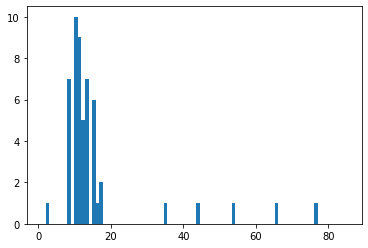

In [53]:
# distribution of missing value counts to find these columns
missing_df = pd.DataFrame(na_percentages, columns=['%'])
plt.hist(na_percentages, bins=85, range=(1,85), )
plt.show()

In [54]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns_to_drop=['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [55]:
# Print percentage of missing values (>5%) in each column
na_counts = df.isna().sum()
na_percentages = round(df.isna().mean() * 100, 2)
null_values = pd.concat([na_counts, na_percentages, df.count()], axis=1, keys=["count", "%", "total"])
print(null_values[null_values['%']>5].sort_values(by=['%'], ascending=False))

                        count      %   total
KKK                    158064  17.74  733157
REGIOTYP               158064  17.74  733157
W_KEIT_KIND_HH         147988  16.61  743233
KBA05_ANTG2            133324  14.96  757897
KBA05_ANTG1            133324  14.96  757897
KBA05_ANTG3            133324  14.96  757897
KBA05_ANTG4            133324  14.96  757897
KBA05_GBZ              133324  14.96  757897
MOBI_REGIO             133324  14.96  757897
PLZ8_ANTG1             116515  13.07  774706
PLZ8_ANTG2             116515  13.07  774706
PLZ8_ANTG3             116515  13.07  774706
PLZ8_ANTG4             116515  13.07  774706
PLZ8_BAUMAX            116515  13.07  774706
PLZ8_HHZ               116515  13.07  774706
PLZ8_GBZ               116515  13.07  774706
VERS_TYP               111196  12.48  780025
SHOPPER_TYP            111196  12.48  780025
HEALTH_TYP             111196  12.48  780025
NATIONALITAET_KZ       108315  12.15  782906
PRAEGENDE_JUGENDJAHRE  108164  12.14  783057
KBA13_ANZA

#### Discussion 1.1.2: Assess Missing Data in Each Column

*(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)*

The columns “TITEL_KZ”, “AGER_TYP” and “KK_KUNDENTYP” contained a percentage of missing values of 99.76%, 76.96% and 65.60% respectively. The first one indicates the ”Academic title flag”, and the third one, “KK_KUNDENTYP”, indicates the consumer pattern over past 12 months. Due to the high percentage of missing values these columns where dropped. Furthermore, the columns “KBA05_BAUMAX”, “GEBURTSJAHR”, “ALTER_HH”, were also dropped, because they contained percentages of missing values above 34%. 

Also, we can see patterns of relationship between several columns that are related to each other, describing certain data. For this reason, if one column is missing, other columns are also missing the values in the same rows, thus having the same percentage of missing values. For example, we can see this pattern in the columns “KBA05_ANTG4”, “KBA05_ANTG1”, “KBA05_BAUMAX”, “MOBI_REGIO”, “KBA05_ANTG3”, “KBA05_ANTG2”, and “KBA05_GBZ”. All these columns are missing 14.96% of its values because they are all related to information regarding “microcells”, so when data is missing in one of these columns, it’s also missing in the other related columns too.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [56]:
# The number of values missing per row
values_missing_per_row = df.isna().sum(axis=1)
values_missing_per_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [57]:
# The average number of values missing per row
df.isna().sum(axis=1).mean()

5.649893797385833

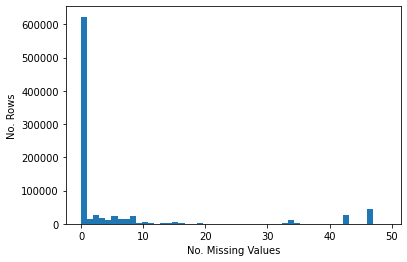

In [58]:
plt.hist(values_missing_per_row, bins=50)
plt.xlabel('No. Missing Values')
plt.ylabel('No. Rows')
plt.show()

In [59]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Dataset_1 >20 missing values
dataset_1 = df[df.isna().sum(axis=1) > 20]
dataset_1

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891164,3.0,2,4.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891171,3.0,2,5.0,4,2,3,5,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891175,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891185,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
na_counts = dataset_1.isna().sum()
na_percentages = round(dataset_1.isna().mean() * 100, 2)
null_values = pd.concat([na_counts, na_percentages, dataset_1.count()], axis=1, keys=["count", "%", "total"])
print(null_values.sort_values(by=['%'], ascending=False))

               count      %  total
PLZ8_ANTG3     93786  99.99      9
MOBI_REGIO     93788  99.99      7
KBA05_ANTG1    93788  99.99      7
KBA05_ANTG2    93788  99.99      7
PLZ8_GBZ       93786  99.99      9
...              ...    ...    ...
SEMIO_KRIT         0   0.00  93795
SEMIO_DOM          0   0.00  93795
SEMIO_KAEM         0   0.00  93795
SEMIO_PFLICHT      0   0.00  93795
ZABEOTYP           0   0.00  93795

[79 rows x 3 columns]


In [61]:
# Dataset_2 <= 20 missing values
dataset_2 = df[df.isna().sum(axis=1) <= 20]
dataset_2

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [62]:
na_counts = dataset_2.isna().sum()
na_percentages = round(dataset_2.isna().mean() * 100, 2)
null_values = pd.concat([na_counts, na_percentages, dataset_2.count()], axis=1, keys=["count", "%", "total"])
print(null_values.sort_values(by=['%'], ascending=False))

                     count     %   total
KKK                  64433  8.08  732993
REGIOTYP             64433  8.08  732993
W_KEIT_KIND_HH       58900  7.39  738526
LP_LEBENSPHASE_FEIN  49651  6.23  747775
LP_LEBENSPHASE_GROB  46830  5.87  750596
...                    ...   ...     ...
SEMIO_DOM                0  0.00  797426
SEMIO_KRIT               0  0.00  797426
SEMIO_RAT                0  0.00  797426
SEMIO_KULT               0  0.00  797426
ZABEOTYP                 0  0.00  797426

[79 rows x 3 columns]


In [63]:
# How much data is missing in each row of the dataset?
def nan_values_plots(col_name):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
   
    ax1.set_title('>20 missing values')       
    sns.countplot(dataset_1, x=col_name, ax=ax1)    
   
    ax2.set_title('<=20 missing values')     
    sns.countplot(dataset_2, x=col_name, ax=ax2)


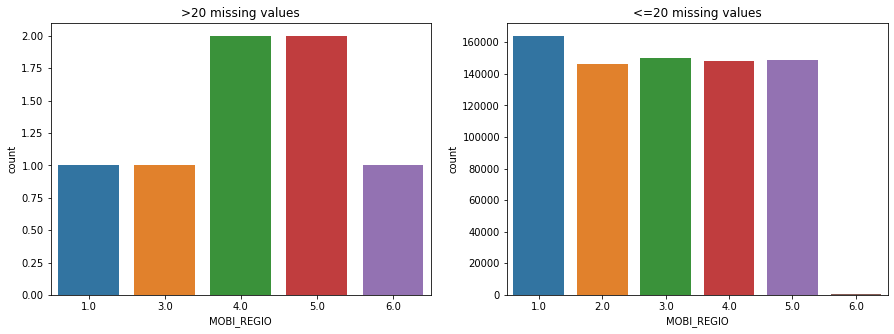

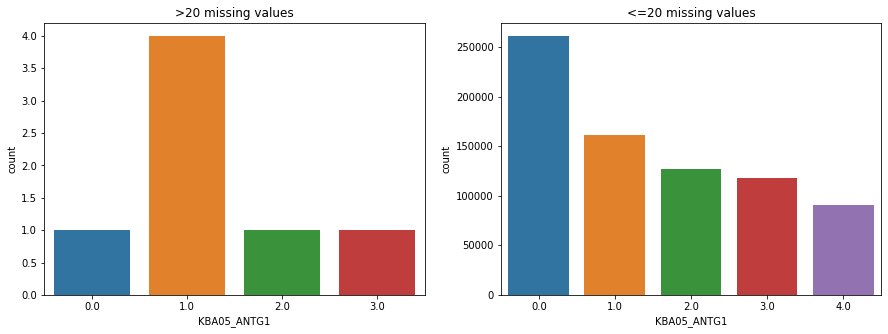

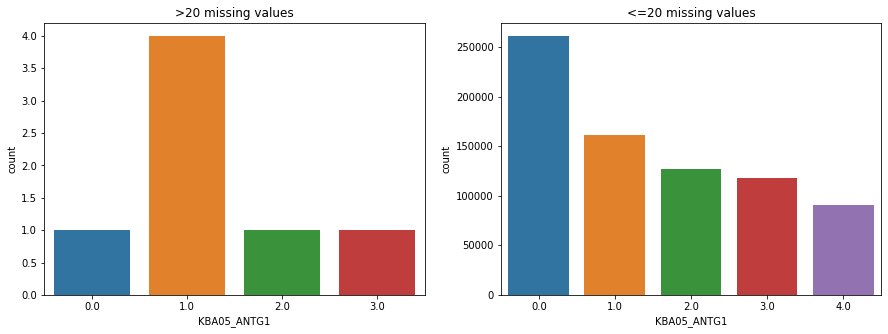

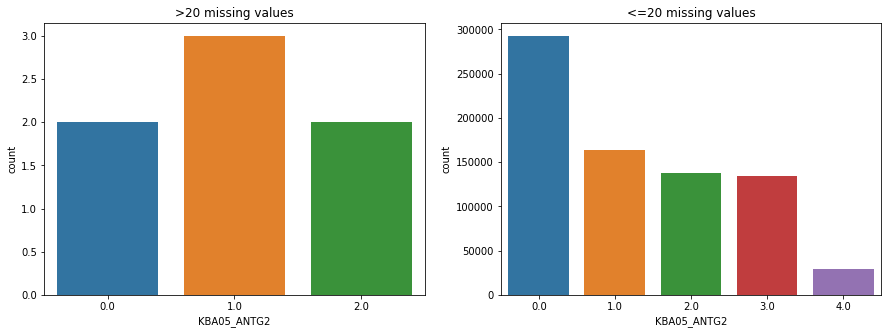

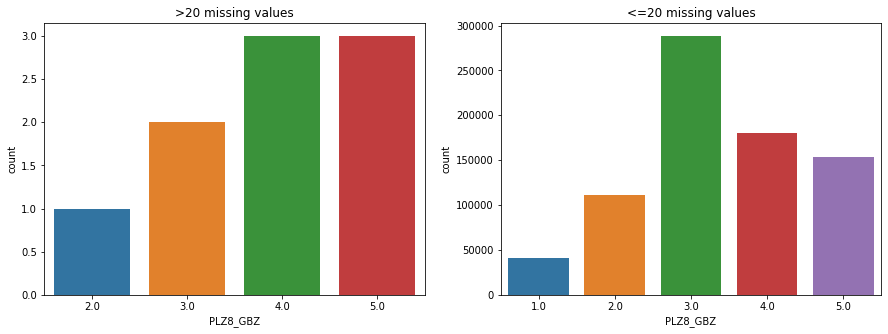

In [64]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

col_names_with_more_missing_values = ['MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG1', 'KBA05_ANTG2', 'PLZ8_GBZ']
for col_name in col_names_with_more_missing_values:
    nan_values_plots(col_name)


In [65]:
dataset_1[col_names_with_more_missing_values].describe()

,MOBI_REGIO,KBA05_ANTG1,KBA05_ANTG1,KBA05_ANTG2,PLZ8_GBZ
count,7.000000,7.000000,7.000000,7.000000,9.000000
mean,4.000000,1.285714,1.285714,1.000000,3.888889
std,1.632993,0.951190,0.951190,0.816497,1.054093
min,1.000000,0.000000,0.000000,0.000000,2.000000
25%,3.500000,1.000000,1.000000,0.500000,3.000000
50%,4.000000,1.000000,1.000000,1.000000,4.000000
75%,5.000000,1.500000,1.500000,1.500000,5.000000
max,6.000000,3.000000,3.000000,2.000000,5.000000


In [66]:
dataset_2[col_names_with_more_missing_values].describe()

,MOBI_REGIO,KBA05_ANTG1,KBA05_ANTG1,KBA05_ANTG2,PLZ8_GBZ
count,757890.000000,757890.000000,757890.000000,757890.000000,774697.000000
mean,2.963530,1.494279,1.494279,1.265586,3.381081
std,1.428878,1.403965,1.403965,1.245181,1.111598
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,0.000000,3.000000
50%,3.000000,1.000000,1.000000,1.000000,3.000000
75%,4.000000,3.000000,3.000000,2.000000,4.000000
max,6.000000,4.000000,4.000000,4.000000,5.000000


In [67]:
low_missing_values = dataset_2.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

* The dataset with fewer missing values ​​has a more even distribution, ​​and fewer atypical values, so we should try to remove or handle these values.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [68]:
# How many features are there of each data type?
filtered_feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]
filtered_feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [69]:
cat_columns = filtered_feat_info[filtered_feat_info.type == 'categorical'].attribute
cat_columns.to_list()

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [70]:
binary_cols = []
multi_cols = []

for col_name in cat_columns:
    unique_values = low_missing_values[col_name].unique()
    if len(unique_values) > 2:
        multi_cols.append(col_name)
    else:
        binary_cols.append(col_name)

print("binary_cols: ", binary_cols)
print("multi_cols: ", multi_cols)



binary_cols:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
multi_cols:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [71]:
# encode all categorical features as an integer array
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
cat_cols_data = ordinal_encoder.fit_transform(low_missing_values[cat_columns])
low_missing_values[cat_columns] = pd.DataFrame(cat_cols_data, columns=cat_columns)
low_missing_values[cat_columns].describe()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
count,713162.000000,709030.000000,713162.000000,709030.000000,713162.000000,685241.000000,685241.000000,709030.000000,709030.000000,683001.000000,680491.000000,713162.000000,680491.000000,713162.000000,713162.000000,713162.000000,707794.000000,707794.000000
mean,0.521241,2.503255,2.798702,6.471585,0.219549,2.910461,1.377032,3.789428,1.459721,0.168495,1.578409,0.008415,0.517916,2.378914,1.609233,0.788880,4.539616,23.532216
std,0.499549,1.537672,2.084659,3.575524,0.413941,3.935688,1.699117,3.520391,1.511617,0.474453,1.025889,0.091345,0.499679,1.407247,2.286777,0.408104,2.489081,12.408821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,2.000000,12.000000
50%,1.000000,3.000000,3.000000,7.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,5.000000,25.000000
75%,1.000000,4.000000,5.000000,10.000000,0.000000,7.000000,3.000000,8.000000,3.000000,0.000000,2.000000,0.000000,1.000000,3.000000,2.000000,1.000000,7.000000,35.000000
max,1.000000,5.000000,5.000000,11.000000,1.000000,10.000000,4.000000,9.000000,4.000000,2.000000,3.000000,1.000000,1.000000,5.000000,6.000000,1.000000,8.000000,43.000000


In [72]:
low_missing_values[binary_cols].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,OST_WEST_KZ
1,1.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0
5,1.0,0.0,0.0,1.0


In [73]:
# one hot encoding
low_missing_values_cat_encoded = pd.get_dummies(low_missing_values, columns=cat_columns, drop_first=True)
low_missing_values_cat_encoded.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_34.0,CAMEO_DEU_2015_35.0,CAMEO_DEU_2015_36.0,CAMEO_DEU_2015_37.0,CAMEO_DEU_2015_38.0,CAMEO_DEU_2015_39.0,CAMEO_DEU_2015_40.0,CAMEO_DEU_2015_41.0,CAMEO_DEU_2015_42.0,CAMEO_DEU_2015_43.0
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,1,0,0,0,0,0,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
low_missing_values_cat_encoded.shape

(797426, 181)

In [75]:
low_missing_values_cat_encoded['CAMEO_DEU_2015_37.0'].head()

1    0
2    0
3    0
4    1
5    0
Name: CAMEO_DEU_2015_37.0, dtype: uint8

#### Discussion 1.2.1: Re-Encode Categorical Features
* All categorical columns were encoded using OrdinalEncoder to transform all values to integers. Then, the categorical columns were One-hot encoded, and the original columns were dropped, keeping only the ones encoded. 




#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [76]:
mixed_columns = filtered_feat_info[filtered_feat_info.type == 'mixed'].attribute
mixed_columns.to_list()


['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [77]:
low_missing_values_cat_encoded['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [78]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
low_missing_values_cat_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182903
8.0     141542
10.0     85767
5.0      84665
3.0      53822
15.0     42521
11.0     35735
9.0      33563
6.0      25651
12.0     24440
1.0      20662
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [79]:
# Assign a value for each decade
low_missing_values_cat_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = low_missing_values_cat_encoded['PRAEGENDE_JUGENDJAHRE'].replace({
   1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 
   10:5, 11:5, 12:5, 13:5, 14:6, 15:6
}, inplace=False)


In [80]:
# Assign a value for each movement
low_missing_values_cat_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = low_missing_values_cat_encoded['PRAEGENDE_JUGENDJAHRE'].replace({
   1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 
   10:0, 11:1, 12:0, 13:1, 14:0, 15:1
}, inplace=False)

In [81]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Assign a value for each wealth value
low_missing_values_cat_encoded['CAMEO_INTL_2015_WEALTH'] = low_missing_values_cat_encoded['CAMEO_INTL_2015'].replace({
    11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2,
    31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4,     
    51:5, 52:5, 53:5, 54:5, 55:5,
}, inplace=False)

In [82]:
# Assign a value ofr each life_stage value
low_missing_values_cat_encoded['CAMEO_INTL_2015_LIFE_STAGE'] = low_missing_values_cat_encoded['CAMEO_INTL_2015'].replace({
    11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5,
    31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5,
    51:1, 52:2, 53:3, 54:4, 55:5, 
}, inplace=False)

#### Discussion 1.2.2: Engineer Mixed-Type Features

* From the “mixed” type columns, only “PRAEGENDE_JUGENDJAHRE” and “CAMEO_INTL_2015” were reengineered using the information from the file “Data_Dictionary.md”. The first one was divided into “PRAEGENDE_JUGENDJAHRE_DECADE” and “PRAEGENDE_JUGENDJAHRE_MOVEMENT”, taking into consideration the information about the decade and dominating movement of person’s youth. Additionally, “CAMEO_INTL_2015” was divided into “CAMEO_INTL_2015_WEALTH” and “CAMEO_INTL_2015_LIFE_STAGE”, taking into consideration the information about wealth and life stage typology. In the next section, all of the original columns of the “mixed” type are dropped. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [83]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

low_missing_values_cat_mixed_encoded = low_missing_values_cat_encoded.drop(columns=mixed_columns, inplace=False)
low_missing_values_cat_mixed_encoded.head()



,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_38.0,CAMEO_DEU_2015_39.0,CAMEO_DEU_2015_40.0,CAMEO_DEU_2015_41.0,CAMEO_DEU_2015_42.0,CAMEO_DEU_2015_43.0,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,0,0,0,0,0,0,6.0,0.0,51,51
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,0,0,0,0,0,0,6.0,1.0,24,24
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,0,0,0,0,0,0,4.0,0.0,12,12
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,0,0,0,0,0,0,4.0,0.0,43,43
5,1.0,3,1,5,2,2,5,3.0,3.0,2,...,0,0,0,0,0,0,2.0,0.0,54,54


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [84]:
def clean_data(in_df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = in_df.copy()
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    import ast
    
    for index, row in feat_info.iterrows():
        column_name = row.attribute

        df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
        df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan) 
        
        try:
            missing_or_unknown_values = ast.literal_eval(row.missing_or_unknown)        
            df[column_name] = df[column_name].replace(to_replace=missing_or_unknown_values, value=np.nan)
        except:        
            print(missing_or_unknown_values)
            print(column_name)

    
    
    # remove selected columns and rows, ...
    # remove columns with more than 20% of missing values
    columns_to_drop=['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df.drop(columns=columns_to_drop, axis=1, inplace=True)

    # <= 20 missing values
    df = df[df.isna().sum(axis=1) <= 20]    

    # select, re-encode, and engineer column values.
    filtered_feat_info = feat_info[~feat_info.attribute.isin(columns_to_drop)]
    cat_columns = filtered_feat_info[filtered_feat_info.type == 'categorical'].attribute.to_list()
    
    # orginal encoder
    from sklearn.preprocessing import OrdinalEncoder
    ordinal_encoder = OrdinalEncoder()
    ordinal_encoded_data = ordinal_encoder.fit_transform(df[cat_columns])
    df[cat_columns] = pd.DataFrame(ordinal_encoded_data, columns=cat_columns)
    
    # onehot encoder
    df = pd.get_dummies(df, columns=cat_columns, drop_first=True)

    # mixed cols
    mixed_columns = filtered_feat_info[filtered_feat_info.type == 'mixed'].attribute.to_list()    
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace({
        1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 
        10:5, 11:5, 12:5, 13:5, 14:6, 15:6
    }, inplace=False)

    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace({
        1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 
        10:0, 11:1, 12:0, 13:1, 14:0, 15:1
    }, inplace=False)

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].replace({
        11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2,
        31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4,     
        51:5, 52:5, 53:5, 54:5, 55:5,
    }, inplace=False)

    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].replace({
        11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5,
        31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5,
        51:1, 52:2, 53:3, 54:4, 55:5, 
    }, inplace=False)

    # drop only original mixed columns
    df.drop(columns=mixed_columns, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [85]:
low_missing_values_cat_mixed_encoded.isna().any().sum()

34

In [86]:
# get num_columns and cat_columns in current dataframe
num_columns = filtered_feat_info[filtered_feat_info.type == 'numeric'].attribute.to_list()
all_columns = low_missing_values_cat_mixed_encoded.columns.to_list()
cat_columns = []
for col_name in all_columns:
    if col_name in num_columns:
        continue
    else:
        cat_columns.append(col_name)

len(cat_columns)

173

In [87]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer
# prepare imputer for num_cols using the `mean` strategy
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# prepare imputer for cat_cols using the `most_frequent` strategy
most_frequent_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# encode num_cols
mean_data = mean_imputer.fit_transform(low_missing_values_cat_mixed_encoded[num_columns])
num_encoded_df = pd.DataFrame(mean_data, columns=low_missing_values_cat_mixed_encoded[num_columns].columns)

# encode cat_cols
most_frequent_data = most_frequent_imputer.fit_transform(low_missing_values_cat_mixed_encoded[cat_columns])
cat_encoded_df = pd.DataFrame(most_frequent_data, columns=low_missing_values_cat_mixed_encoded[cat_columns].columns)

In [88]:
num_encoded_df.describe()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000
mean,1.729408,0.004152,8.357531,0.040654,1993.264308,619.670061
std,1.156396,0.068551,15.615419,0.323339,3.299689,337.404972
min,0.000000,0.000000,1.000000,0.000000,1985.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,1992.000000,386.000000
50%,1.000000,0.000000,4.000000,0.000000,1992.000000,554.000000
75%,2.000000,0.000000,9.000000,0.000000,1993.000000,773.000000
max,45.000000,4.000000,595.000000,23.000000,2016.000000,2300.000000


In [89]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
# prepare scaler
standard_scaler = StandardScaler()
# scale num_cols
scaled_data = standard_scaler.fit_transform(num_encoded_df)
num_scaled_df = pd.DataFrame(scaled_data, columns=num_encoded_df.columns)
num_scaled_df.describe()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05
mean,4.150489e-17,-7.662990e-19,3.927728e-17,2.760459e-17,9.322990e-15,-4.226941e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.495517e+00,-6.056999e-02,-4.711712e-01,-1.257319e-01,-2.504573e+00,-1.836578e+00
25%,-6.307603e-01,-6.056999e-02,-4.071319e-01,-1.257319e-01,-3.831600e-01,-6.925512e-01
50%,-6.307603e-01,-6.056999e-02,-2.790532e-01,-1.257319e-01,-3.831600e-01,-1.946329e-01
75%,2.339961e-01,-6.056999e-02,4.114330e-02,-1.257319e-01,-8.010091e-02,4.544392e-01
max,3.741852e+01,5.829049e+01,3.756818e+01,7.100711e+01,6.890258e+00,4.980161e+00


In [90]:
# concat num_cols and cat_cols
scaled_df = pd.concat([num_scaled_df, cat_encoded_df], axis=1)
print(scaled_df.shape)
scaled_df.isna().any().sum()

(797426, 179)


0

In [91]:
# check if there're still nan values in dataframe
na_counts = scaled_df.isna().sum()
na_percentages = round(scaled_df.isna().mean() * 100, 2)
null_values = pd.concat([na_counts, na_percentages, scaled_df.count()], axis=1, keys=["count", "%", "total"])
print(null_values.sort_values(by=['%'], ascending=False))


                            count    %   total
ANZ_PERSONEN                    0  0.0  797426
CAMEO_DEU_2015_3.0              0  0.0  797426
ZABEOTYP_3.0                    0  0.0  797426
ZABEOTYP_4.0                    0  0.0  797426
ZABEOTYP_5.0                    0  0.0  797426
...                           ...  ...     ...
FINANZTYP_1.0                   0  0.0  797426
FINANZTYP_2.0                   0  0.0  797426
FINANZTYP_3.0                   0  0.0  797426
FINANZTYP_4.0                   0  0.0  797426
CAMEO_INTL_2015_LIFE_STAGE      0  0.0  797426

[179 rows x 3 columns]


### Discussion 2.1: Apply Feature Scaling

* “SimpleImputer” was used in order to clean the missing values in the data frame. For the categorical columns the “most_frequent” strategy was used, and for the numerical columns the “mean” strategy was used. Afterwards, the numerical columns were scaled with “StandardScaler”. For these processes the data frame was split into categorical and numerical columns, so both splits were combined at the end. Finally, we checked if all missing values were handled. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [92]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pcs = PCA()
pcs_t = pcs.fit_transform(scaled_df)

In [93]:
# Investigate the variance accounted for by each principal component.
pcs_summary = pd.DataFrame({
    '% applied variance': np.round(pcs.explained_variance_ratio_, 4) * 100,
    '% cumulative variance': np.cumsum(pcs.explained_variance_ratio_) * 100
})

pcs_labels = [f"PC{i+1}" for i in range(len(scaled_df.columns))]
pcs_summary.index = pcs_labels
pcs_summary[0:25]


,% applied variance,% cumulative variance
PC1,76.02,76.017623
PC2,4.65,80.664903
PC3,3.19,83.850232
PC4,2.64,86.494400
PC5,0.95,87.445775
PC6,0.81,88.258377
PC7,0.75,89.006045
PC8,0.65,89.658776
PC9,0.63,90.285205
PC10,0.58,90.867906


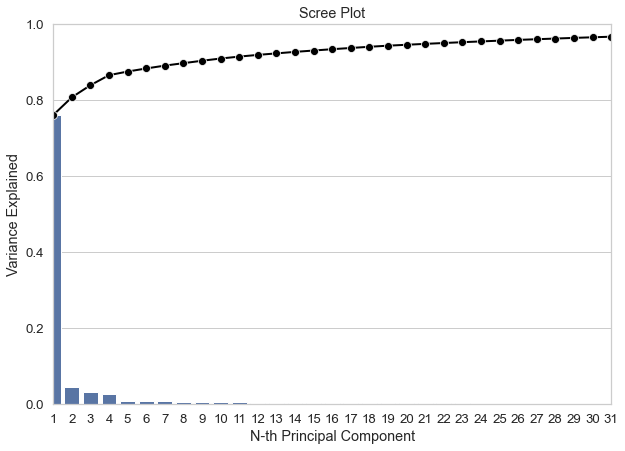

In [94]:
"""
Scree Plot:
    https://medium.com/@jodancker/a-brief-introduction-to-principal-component-analysis-99056300600b
    https://en.wikipedia.org/wiki/Scree_plot
"""
PC_components = np.arange(pcs.n_components_) + 1

sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=PC_components, y=pcs.explained_variance_ratio_, color='b')
sns.lineplot(x=PC_components-1,
                 y=np.cumsum(pcs.explained_variance_ratio_),
                 color='black',
                 linestyle='-',
                 linewidth=2,
                 marker='o',
                 markersize=8
                 )

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.show()


In [95]:
# Re-apply PCA to the data while selecting for number of components to retain.
pcs = PCA(n_components=25)
pca_data = pcs.fit_transform(scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

* PCA was applied without knowing the number of important components that conserved most of the original data’s variance. Then, we displayed the cumulative variance for each component and displayed the Scree Plot with the cumulative variance. With these steps, I noticed using 25 components explained 95.56% of the original data’s variance, so I decided to use 25 principal components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

MOBI_REGIO           0.039165
KBA05_ANTG1          0.037002
KBA05_GBZ            0.032648
INNENSTADT           0.028887
KONSUMNAEHE          0.028844
FINANZ_MINIMALIST    0.027853
PLZ8_ANTG1           0.026932
PLZ8_GBZ             0.022093
ONLINE_AFFINITAET    0.019454
BALLRAUM             0.019155
Name: 0, dtype: float64

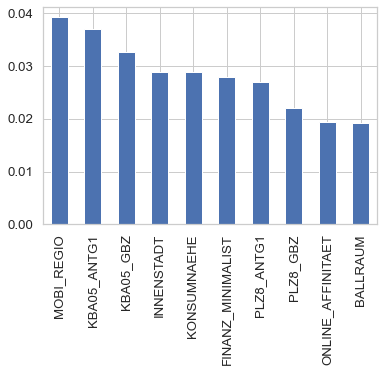

In [121]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_pc_weights(pca, index):
    data = pd.DataFrame(pca.components_, columns = scaled_df.columns)
    display(data.iloc[index].sort_values(ascending = False)[:10])
    data.iloc[index].sort_values(ascending = False)[:10].plot(kind='bar')
    

map_pc_weights(pcs, 0)

SEMIO_REL                       0.331896
SEMIO_KULT                      0.321325
SEMIO_FAM                       0.284059
SEMIO_PFLICHT                   0.263347
SEMIO_TRADV                     0.244182
SEMIO_MAT                       0.223990
FINANZ_SPARER                   0.208568
PRAEGENDE_JUGENDJAHRE_DECADE    0.195682
SEMIO_SOZ                       0.188775
FINANZ_UNAUFFAELLIGER           0.169877
Name: 1, dtype: float64

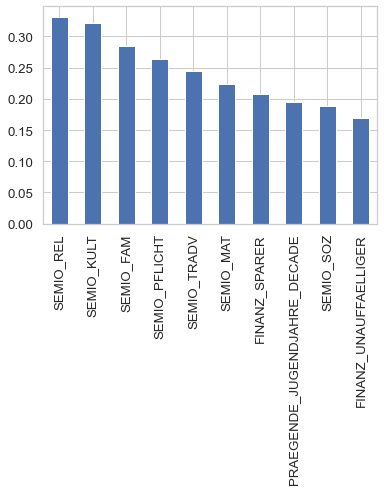

In [122]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pc_weights(pcs, 1)

SEMIO_VERT              0.374946
SEMIO_SOZ               0.242049
SEMIO_FAM               0.192482
FINANZ_MINIMALIST       0.190410
SEMIO_KULT              0.176560
SEMIO_LUST              0.156429
FINANZ_VORSORGER        0.137184
BALLRAUM                0.105682
INNENSTADT              0.100495
ALTERSKATEGORIE_GROB    0.099636
Name: 2, dtype: float64

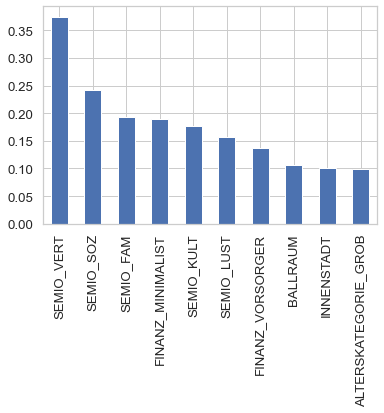

In [123]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pc_weights(pcs, 2)

### Discussion 2.3: Interpret Principal Components

* Mapping the weights for the first three principal components with their corresponding feature names indicated that the first PC is correlated with “MOBI_REGIO”, “KBA05_ANTG1”, “KBA05_GBZ”, among others. The second PC is highly correlated with “SEMIO_REL”, “SEMIO_KULT”, “SEMIO_FAM”, among others. The third PC is highly correlated with “SEMIO_VERT”, “SEMIO_SOZ”, “SEMIO_FAM”, among others. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [118]:
!pip install yellowbrick

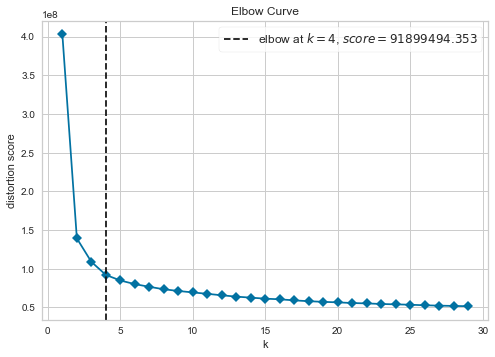

<AxesSubplot: title={'center': 'Elbow Curve'}, xlabel='k', ylabel='distortion score'>

In [119]:
"""
KElbowVisualizer:
    https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
"""

# Over a number of different cluster counts...
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,30),timings = False,locate_elbow=True,)
visualizer.fit(pca_data)
visualizer.title = 'Elbow Curve'
visualizer.show()
    
    

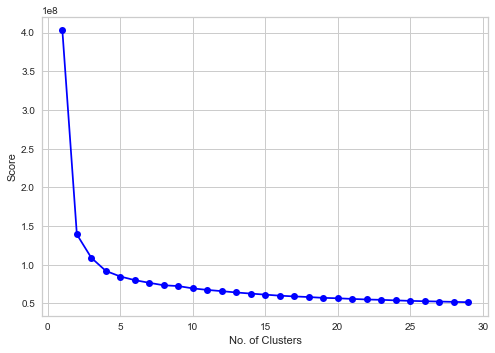

In [120]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
clusters = np.arange(1,30,1)
scores = []
for cluster in clusters:
    model = KMeans(n_clusters = cluster)
    model.fit(pca_data)    
    score = np.abs(model.score(pca_data))
    scores.append(score)

plt.plot(clusters, scores, marker = 'o', color = 'blue')
plt.xlabel('No. of Clusters')
plt.ylabel('Score')
plt.show()


In [100]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters = 4)
model.fit(pca_data)
pred_data = model.predict(pca_data)


### Discussion 3.1: Apply Clustering to General Population

* To find the optimal number of clusters the “KElbowVisualizer” class, from the “yellowbrick” library, was used. Additionally, I plotted the scores for different number of clusters. For both methods a range of 1 to 30 clusters was used. The Elbow curves indicated that the optimal number of clusters is 4, so I retrained the Kmeans model for this number of clusters.*

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [101]:
# Load in the customer demographics data.
customers_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [104]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean_df = clean_data(customers_df)

"""
if the customers data is missing the `GEBAEUDETYP_6.0` it means
the column `GEBAEUDETYP` didn't have a value of 6.0 when One-hot encoding 
was applied. Thus, all values in these column should be set to `0`.
This way, the PCA model will receive the expected number of columns
(that were used during training).
"""
if ~('GEBAEUDETYP_6.0' in customers_clean_df):
    customers_clean_df['GEBAEUDETYP_6.0'] = 0
customers_clean_df = customers_clean_df[scaled_df.columns]

[-1]
CAMEO_DEUG_2015
[-1]
CAMEO_DEU_2015
[-1]
CAMEO_INTL_2015


In [105]:
# encode num_cols
customers_mean_data = mean_imputer.transform(customers_clean_df[num_columns])
customers_num_encoded_df = pd.DataFrame(customers_mean_data, columns=customers_clean_df[num_columns].columns)

# encode cat_cols
customers_most_frequent_data = most_frequent_imputer.transform(customers_clean_df[cat_columns])
customers_cat_encoded_df = pd.DataFrame(customers_most_frequent_data, columns=customers_clean_df[cat_columns].columns)

# scale num_cols
customers_scaled_data = standard_scaler.transform(customers_num_encoded_df)
customers_num_scaled_df = pd.DataFrame(customers_scaled_data, columns=customers_num_encoded_df.columns)

# concat num_cols and cat_cols
customers_scaled_df = pd.concat([customers_num_scaled_df, customers_cat_encoded_df], axis=1)

In [106]:
# Apply PCA
pca_customers_data = pcs.transform(customers_scaled_df)

In [110]:
# K-means predict
pred_customers_data = model.predict(pca_customers_data)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

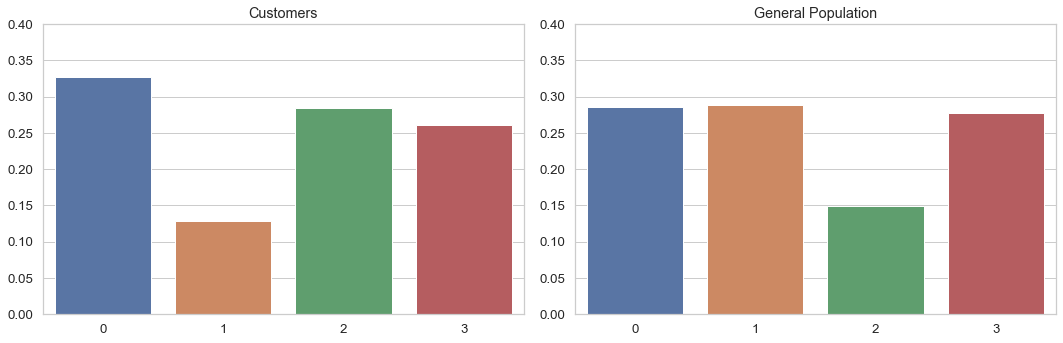

In [133]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Customers')
ax1.set(ylim=(0, 0.4))
unique, counts = np.unique(pred_customers_data, return_counts=True)
sns.barplot(x=unique, y=counts/counts.sum())

ax2 = fig.add_subplot(122)
ax2.title.set_text('General Population')
ax2.set(ylim=(0, 0.4))
unique, counts = np.unique(pred_data, return_counts=True)
sns.barplot(x=unique, y=counts/counts.sum())

fig.tight_layout() 
plt.show()

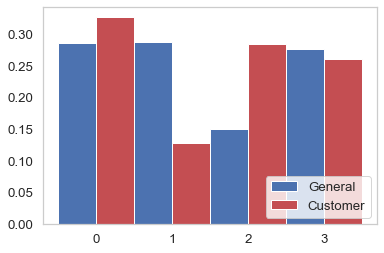

In [163]:
# Show both plots combined:
# https://knowledge.udacity.com/questions/905904
from collections import Counter

# generating proportion for the customer clusters.
unique, counts = np.unique(pred_data, return_counts=True)

# generating proportion for the azdias clusters.
unique1, counts1 = np.unique(pred_customers_data, return_counts=True)

# configuring the graph
width = .5
plt.bar(unique1, counts/counts.sum(), width ,label='General')
plt.bar(unique+width, counts1/counts1.sum(), width,  color='r' , label='Customer')
plt.xticks(unique + width * 0.5, unique)
plt.legend(loc='lower right')
plt.grid()
plt.show()

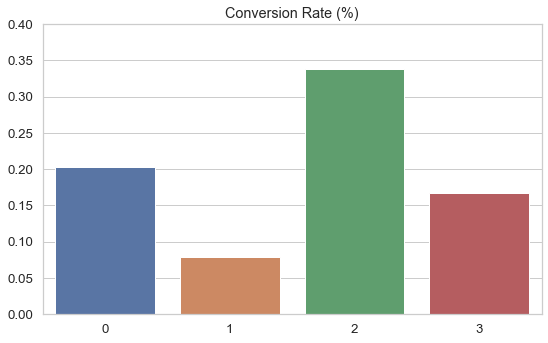

[0.20302263 0.07946708 0.33725139 0.1671395 ]


In [173]:
# Conversion Rate
# Percentage of customers / general demographics
_, customer_counts = np.unique(pred_customers_data, return_counts=True)
_unique, general_counts = np.unique(pred_data, return_counts=True)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Conversion Rate (%)')
ax1.set(ylim=(0, 0.4))

sns.barplot(x=[0,1,2,3], y=customer_counts/general_counts)

fig.tight_layout() 
plt.show()

print(customer_counts/general_counts)

In [172]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_2 = model.cluster_centers_[2]
inverse_pca_cluster_2_data = pcs.inverse_transform(cluster_2)
inverse_pca_cluster_2_df = pd.DataFrame(data = inverse_pca_cluster_2_data, index = scaled_df.columns)
inverse_pca_cluster_2_df = inverse_pca_cluster_2_df.transpose()
inverse_pca_cluster_2_df[num_encoded_df.columns] = standard_scaler.inverse_transform(inverse_pca_cluster_2_df[num_encoded_df.columns])
inverse_pca_cluster_2_df = inverse_pca_cluster_2_df.transpose()
display(inverse_pca_cluster_2_df.head(25))

,0
ANZ_PERSONEN,2.034295
ANZ_TITEL,0.007993
ANZ_HAUSHALTE_AKTIV,2.124139
ANZ_HH_TITEL,0.032520
MIN_GEBAEUDEJAHR,1993.848396
KBA13_ANZAHL_PKW,704.991222
ALTERSKATEGORIE_GROB,2.884643
FINANZ_MINIMALIST,3.861559
FINANZ_SPARER,2.337427
FINANZ_VORSORGER,3.640247


In [155]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_1 = model.cluster_centers_[1]
inverse_pca_cluster_1_data = pcs.inverse_transform(cluster_1)
inverse_pca_cluster_1_df = pd.DataFrame(data = inverse_pca_cluster_1_data, index = scaled_df.columns)
inverse_pca_cluster_1_df = inverse_pca_cluster_1_df.transpose()
inverse_pca_cluster_1_df[num_encoded_df.columns] = standard_scaler.inverse_transform(inverse_pca_cluster_1_df[num_encoded_df.columns])
inverse_pca_cluster_1_df = inverse_pca_cluster_1_df.transpose()
display(inverse_pca_cluster_1_df.head(25))

,0
ANZ_PERSONEN,1.450879
ANZ_TITEL,0.001870
ANZ_HAUSHALTE_AKTIV,15.282761
ANZ_HH_TITEL,0.066890
MIN_GEBAEUDEJAHR,1992.676423
KBA13_ANZAHL_PKW,526.000968
ALTERSKATEGORIE_GROB,2.716971
FINANZ_MINIMALIST,2.366894
FINANZ_SPARER,3.001507
FINANZ_VORSORGER,3.288774


### Discussion 3.3: Compare Customer Data to Demographics Data

*(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)*

* Cluster#2 was, proportionally, the smallest cluster of the general population, but was the second largest cluster of the customers. If we analyze the data as conversion rates, that is, we divide the number of customers in each cluster by the number of people in each cluster, we can see that Cluster#2 has a conversion rate of ~33.7%, while Cluster#1 only ~7.9%. In other words, we could argue that ~33.7% of Cluster#2’s population is likely to become a customer, but only ~7.9% of Cluster#1 is likely.

* Cluster#2 had an average number of adults in the household (ANZ_PERSONEN) of 2, while Cluster#1 was nearer to 1. Furthermore, the ANZ_HAUSHALTE_AKTIV column indicated that Cluster#2 had an average of 2 households in the building, while Cluster#1 had 15. The column FINANZ_MINIMALIST was near to “low” in Cluster#2, but “high” in Cluster#1. Additionally, the column FINANZ_HAUSBAUER was close to “high” in Cluster#2, and closer to “low” in Cluster#1. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.